
Mission 2. 한국 이미지 데이터 셋을 분류하시오

목차


1.   Mission 1의 결과 분석하기
- 1-1. 데이터와 모델 불러오기
- 1-2. 각 클래스 별 학습 정확도 출력
- 1-3. 저장된 데이터 분석 및 시각화
2. 1의 분석 기반으로 성능 향상을 위한 작업을 수행한다.
- 2-1. 에포크 수 결정
- 2-2. 러닝 스케줄러 조절
- 2-3. 데이터 증강
3.   선택지들의 성능 경향을 파악하고 최적 모델을 학습시킨다.



###라이브러리 import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
cudnn.benchmark = True

import torchvision
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

from torchsummary import summary
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import os

from warnings import filterwarnings
filterwarnings('ignore')

import pickle

In [ ]:
#피클 설정
def save_pickle(data, route):
    '''
    data를 받아서 pickle 형식으로 저장
    '''
    with open(route, 'wb') as file:
        pickle.dump(data, file)
    print(f"{route} 저장 완료")

def load_pickle(route):
    '''
    저장된 pickle 파일을 불러오기
    '''
    with open(route, 'rb') as file:
        return pickle.load(file)

def save_model(model, optimizer, num_epochs, loss, accuracy_score):
    '''
    모델의 checkpoint를 '*.pt' 확장자 파일로 저장하는 함수
    '''
    # 모델을 저장할 경로를 지정하고 .pt 확장자를 사용
    now = datetime.now().strftime('%y%m%d%H%M%S')
    model_save_path = f'Mission2_{now}_{num_epochs}epochs_{round(accuracy_score, 2)}.pt'

    # 모델의 상태 및 다른 중요한 정보를 저장
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': num_epochs,  # 현재 에폭
        'loss': loss.item()  # 현재 손실
    }

    torch.save(checkpoint, model_save_path)

def save_scores(scores):
    '''
    epoch별 train accuracy와 validation accuracy를 pickle 파일로 저장
    '''
    with open('scores.pickle', 'wb') as file:
        pickle.dump(scores, file)

def load_scores(route):
    '''
    epoch별 train accuracy와 validation accuracy가 저장된 파일을 불러오기
    '''
    with open(route, 'rb') as file:
        return pickle.load(file)

def load_model(model, optimizer, model_path):
    '''
    저장된 모델 checkpoint를 불러오는 함수
    '''
    checkpoint = torch.load(model_path)

    # 모델의 상태 및 중요한 정보를 불러옴
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return model, optimizer, epoch, loss

# 채점시 사용되는 코드
# 본인의 코드에 사용해도 된다.
@torch.no_grad()
def validate_epoch(model: nn.Module, testloader: torch.utils.data.dataloader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(testloader, total=len(testloader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.cat(accuracies).float().mean() * 100
    return accuracy.item()

# 클래스별 채점 코드
@torch.no_grad()
def validate_epoch_by_class(model: nn.Module, testloader: torch.utils.data.dataloader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model BY CLASSES in percent.
    '''
    # 초기 설정
    total_counts = {testloader.dataset.classes[i] : 0 for i in range(len(testloader.dataset.classes))}
    true_counts = {testloader.dataset.classes[i] : 0 for i in range(len(testloader.dataset.classes))}

    # 클래스별 채점 수행
    model.eval()
    for images, labels in tqdm(testloader, total=len(testloader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        results = pred == labels

        # tensor를 구성하는 각 원소의 라벨과 결과를 확인하여, 클래스별 정답 개수와 데이터 개수로 저장
        for i in range(len(results)):
            total_counts[testloader.dataset.classes[labels[i].item()]] += 1
            true_counts[testloader.dataset.classes[labels[i].item()]] += 1 if results[i].item() else 0

    # 데이터프레임으로 생성
    df = pd.merge(
        pd.DataFrame(total_counts, index=['total']).T.reset_index(),
        pd.DataFrame(true_counts, index=['true']).T.reset_index()
    )

    # accuracy 도출
    df['accuracy'] = df['true'] / df['total']

    return df.sort_values('accuracy', ascending=False).reset_index(drop=True)


In [ ]:
#코랩 사용시 구글 드라이브로 현재 디렉토리를 변경한다
import os
os.chdir('/content/drive/MyDrive/개별 폴더')

# 1. Mission 1의 결과를 분석한다

##1-1. 데이터와 모델 불러오기

In [ ]:
# 저장된 평균, 표준편차 로딩
load_route = '/content/drive/MyDrive/데이터 병합 관련/231031172524_normalize-params.pickle'
#해당 피클은 Mission1의 전처리 단계에서 저장된 데이터의 평균과 표준편차이다. 다운 링크는 아래 첨부.
mean = load_pickle(load_route)['평균']
std = load_pickle(load_route)['표준편차']

# 데이터 변환 정의
transform = T.Compose([
    T.Resize((224, 224)),  # 이미지 크기 조정
    T.ToTensor(),  # 이미지를 텐서로 변환
    T.Normalize(mean=mean, std=std)  # 이미지 정규화
])

# 데이터셋 로딩
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/데이터/train', transform=transform)
testset =  torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/데이터/val', transform=transform)

# 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

[normalize-params](https://drive.google.com/file/d/10Lcr6CnSIjHTV4mgAmUtY0-yD8ltIxiN/view?usp=sharing)



In [ ]:
# 모델 불러오기
# 모델과 옵티마이저를 초기화
model = models.resnet18(pretrained=False)
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
optimizer = torch.optim.Adam(model.parameters())

# 저장된 모델을 불러오기
model_path = '/content/drive/MyDrive/데이터 병합 관련/Mission1.pt'
model, optimizer, epoch, loss = load_model(model, optimizer, model_path)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

cuda:0


##1-2. 각 클래스 별 학습 정확도 출력

In [ ]:
class_accuracy_df = validate_epoch_by_class(model, testloader, device)
class_accuracy_df

measuring accuracy:   0%|          | 0/66 [00:00<?, ?it/s]

,index,total,true,accuracy
0,알밥,93,84,0.903226
1,미역국,98,88,0.897959
2,누룽지,98,85,0.867347
3,김밥,111,96,0.864865
4,잡곡밥,103,89,0.864078
5,계란국,97,82,0.845361
6,새우볶음밥,96,81,0.843750
7,시래기국,108,90,0.833333
8,훈제오리,113,94,0.831858
9,육개장,122,101,0.827869


In [ ]:
now = datetime.now().strftime('%y%m%d%H%M%S')
save_route = f"{now}_class-accuracy.pickle"
save_pickle(class_accuracy_df, save_route)

#추후 클래스 별 데이터 증강을 위해 클래스 별 정확도를 저장한다.

231102174815_class-accuracy.pickle 저장 완료


## 1-3. 저장된 데이터 분석 및 시각화

* Mission 1에서 저장된 피클을 이용해 결과를 출력한다.
* [scores.pickle](https://drive.google.com/file/d/1NZvg0Jttm1zGud0FS4Pz6s2HARFdRp47/view?usp=sharing)

### 저장된 데이터 평균과 최댓값 분석

In [ ]:
score_df = pd.DataFrame(load_scores('/content/drive/MyDrive/데이터 병합 관련/231101100145_scores.pickle'), index=['train', 'val']).T
score_df

,train,val
0,19.182568,26.750834
1,33.036645,37.613148
2,42.994076,37.708431
3,51.370821,51.310146
4,57.392909,55.216770
...,...,...
95,99.889858,72.582176
96,99.898788,72.796570
97,99.895812,72.606003
98,99.904742,72.868034


In [ ]:
#평균과 최댓값
print(score_df['val'].mean())
print(score_df['val'].max())

max_index=score_df['val'].idxmax()
sliced_df = score_df.loc[:max_index, :]
mean_value=score_df['val'].mean()
result = sliced_df[sliced_df['val'] > mean_value]
result

69.07074766159057
72.96331787109375


,train,val
22,99.538594,69.604576
24,99.505849,70.557411
25,99.621945,69.199615
26,99.618968,70.581230
27,99.755902,71.414963
29,99.630875,70.652695
30,99.764832,71.486420
31,99.797577,69.961891
32,99.839252,71.772270
33,99.863067,72.606003


### 결과 시각화해서 분석하기

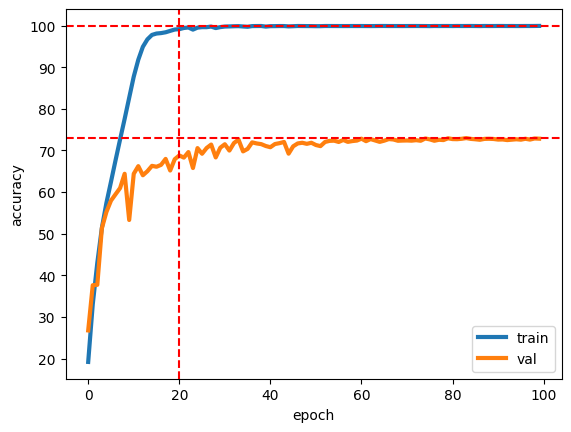

In [ ]:
score_df.plot(kind='line', linewidth=3)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.axhline(99.90, color='red', linestyle='--')
plt.axhline(72.90, color='red', linestyle='--')
plt.axvline(20, color='red', linestyle='--')
plt.xticks([0, 20, 40, 60, 80, 100])
plt.show()



---



# 2. 1의 분석을 기반으로 성능 향상을 위한 작업을 수행한다.

## 2-1. 에포크 수 설정하기

**결과 분석**
* 33 epoch 이후의 수행에서 성능이 일정 수준으로 수렴하는 점을 확인할 수 있다.
* 50 epoch 이후의 수행에서 accuracy가 튀지 않고 안정화되는 경향을 볼 수 있다.
* 100 epoch 수행에서 오버피팅이 발생하지 않는 점을 확인할 수 있다.

**에포크 수 설정**
* 최종 모델 학습은 **50 epoch**로 진행한다.
* 다만 최적의 하이퍼파라미터를 찾기 위해서는 많은 수행을 해보아야 하는데, 이 과정에서 시간적 효율성을 고려해야 한다. 이때 100번의 epoch 수행에서 오버피팅은 아직 발견되지 않았기 때문에, 아래의 실험 과정 수행에서는 모두 **20 epoch** 를 기준으로 진행한다.

## 2-2. 러닝 스케줄러 조절

**실험 목적:**

*   Learning rate를 조절해 모델의 학습 성능을 높이는 것을 목적으로 한다.




**배경 설명:**
- 러닝 레이트란?
    - learning rate 는 각 반복 단계에 학습는데 단계 크기를 결정하는 하이퍼파라미터다. 신경망의 가중치와 편향을 업데이트 하기 위해 역전파를 실행할 때, 경사하강법을 통해 최적의 해를 찾을 수 있다. 이때, 학습률이 최적의 해를 찾기 위해 사용된다. 적절한 학습률은 학습 성능에 영향을 끼칠 수 있는데, 작은 학습률은 느린 속도와 Local Minima에 빠질 수 있으며, 따라서 적절한 학습률을 찾아 학습시켜야한다.
- 즉, 오차값을 최소화 할 수 있는 가중치들을 찾기 위해 경사하강법의 최적해를 찾아야한다. 따라서 Optimizer란 손실함수의 값을 최소화하는 모델의 가중치이고, learning rate는 이 파라미터 중 하나라고 할 수있다.
- 최적해를 찾을 때 다음과 같은 방법을 이용할 수 있다.
    - 학습 방향성을 결정하는 optimizer
        - SDG
            - 지그재그 형식으로 기울기를 탐핵사는 방법이다. 다만 local minima에 빠질 수 있다.
        - Momentum
            - SDG에 속도라는 개념을 포함해 이 이전 기울기에 상응하게 가속을 진행한다.
    - 학습률을 조정하는 optimizer
        - AdaGrad
            - 이 학습은 학습률을 조절하는 기술로, 학습률을 점점 작게 감소시킨다. 다만 이는 무한히 학습하면 갱신량이 0이 된다는 단점을 가지고 있다.
        - RMSprop
            - AdaGrad의 단점을 보완한 값으로 현 시점으로부터 먼 과거의 기울기는 조금 반영하고 최신의 기울기를 많이 이용한 지수이동평균을 이용해 학습률을 업데이트한다
    - Adam
        - Momentumrhk RMSprop을 결합한 방법이다. 방향성과 스텝 사이즈를 적절하게 표현할 수 있다.

- 기본 모델을 학습시킬 때에는 Adam을 사용하도록 했다. 또한 더불어 LambdaLR를 이용해 학습률이 0.95배씩 감소하는 Learning Rate Scheduler를 삽입하였다. 이 실험에서는 더 나은 학습효과를 위해 Adam과 더불어 추가적으로 학습률을 조정하는 방법에 대해 고안했다. 아래에서는 사용하는 Learning Rate Scheduler를 변형해 Optimizer에 대한 추가적인 실험을 진행한 내용이다.

- Learning Rate Scheduler 란 학습률을 동적으로 움직이는 기법으로 본 실험에서는 보다 나은 학습률을 찾기 위해 학습률 스케줄링을 진행했다. 특히 Step Decay 전략을 사용해 미리 정의된 간격마다 학습률을 일정 비율로 감소시키는 방법을 선택해 모델의 학습 효율성을 높이고자 하였다.

**실험 내용:**

- 기존에는 매 epoch 마다 학습률이 LambdaLR 스케줄러를 채택하였다.


> `scheduler = optim.lr_scheduler.(LambdaLRoptimizer, lr_lambda=lambda epoch: 0.95 ** epoch)`


- 아래의 실험에서는 10 epochs 마다 학습률이 줄어드는 방식을 채택하고, 두 실험의 결과를 비교하도록 한다.

> `scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)`


### 모델 불러오기

In [ ]:
# ResNet-18 모델 로딩
model = models.resnet18(pretrained=False)

# 분류할 클래스 수에 맞게 모델의 출력 레이어 수정
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

summary(model, (3, 224, 224))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [

###모델 학습시키기

**참고**



1.   가상환경의 불안정성 때문에 수행시간이 비정상적으로 오래걸려 불가피하게 16에포크 이후에 Validation accuarcy 검증을 하기로 결정하였다.
2.   해당 단계에서는 현 환경에서 직접 학습을 진행하지 않고 체크포인트와 스코어 저장 피클을 첨부하는 것으로 대신한다.

[lr 조절 실험 모델 score pickle](https://drive.google.com/file/d/1S_0uuUxL6oJS_KwM0tusLt8Bzk4HRaAP/view?usp=sharing)

[lr 조절 실험 모델 pt](https://drive.google.com/file/d/1toh46NbmvAkiumh-XOJSLoUfC1UKy9SE/view?usp=sharing)



In [ ]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 최적화 알고리즘 선택
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# learning Rate Scheduler
# 10 에폭마다 lr 감소하도록 함
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 훈련 반복
num_epochs = 20
max_val_accuracy = 0
scores = {}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / (i + 1)
    accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    #16이상 에포크마다 valduation 계산 (시간관계상..)
    val_accuracy = 0
    if (epoch + 1) >= 16 or (epoch + 1) % 15 == 0:  # 16 에폭 이후부터는 모든 에폭에 검증을 수행하도록 설정
        val_accuracy = validate_epoch(model, testloader, device)
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

    # accuracy 저장
    scores[epoch] = [accuracy, val_accuracy]

		# 모델 저장
    save_model(model, optimizer, epoch, loss, val_accuracy)

		# 스케줄러 업데이트
    scheduler.step()

print('Training Finished')

now = datetime.now().strftime('%y%m%d%H%M%S')
save_route = f"{now}_scores.pickle"
save_pickle(scores, save_route)
save_model(model, optimizer, epoch, loss, val_accuracy)

### 결과 분석하기



* 해당 단계는 score을 저장한 pickle을 불러와 분석하도록한다.





In [ ]:
scorelr_df = pd.DataFrame(load_scores('/content/drive/MyDrive/데이터 병합 관련/231101235121_scores.pickle'), index=['test', 'val']).T
scorelr_df[16:]

,test,val
16,82.413003,70.533585
17,82.549936,70.771797
18,82.320722,70.343018
19,82.543982,70.581230


*   기존 모델의 accuarcy 는 20 에폭의 지점에서 68.79 를 기록했다.
*   러닝레이트를 10 epoch마다 조절했을 때 기존 모델에 비해 학습률이 올라가는 것을 확인할 수 있었다. (20 epochs 기준 70.581)
* **결론: 러닝레이트를 10 epoch 마다 조절하는 방법을 채택한다**

## 2-3. 데이터 증강

**실험 목적:**

*  데이터 증강을 수행해 모델의 정확도를 높인다. 이때, 다양한 증강 기법을 이용해 최적의 데이터 증강기법을 채택한다.


**배경 설명:**
* 데이터 증강이란?
  * 딥러닝 모델의 주요 목표는 학습 데이터를 통해 얻은 특징을 새로운 데이터에 적용하여 정확하게 예측할 수 있도록, 일반화를 잘 할 수 있는 모델을 만들고자 하는 것이다. 이때 모델 내 수많은 파라미터를 높은 수준으로 학습하기 위해서는 그만큼 **충분한 데이터**가 필요하다. 하지만 현실적으로 많은 데이터를 확보하는 데에는 어려움이 있다. 따라서 데이터 증강을 통해 표본을 늘리는 방법이 효과적인 선택지가 될 수 있다.
* 데이터 증강 종류
  * RandomHorizontalFlip : 이미지를 수평 방향으로 변형한다.
  * RandomRotation : 이미지의 각도를 랜덤하게 회전한다.
  * RandomAffine : 이미지를 랜덤하게 Affine 변형한다.
  * ColorJitter : 이미지의 색상(명도, 대비, 채도 등)을 변형한다.


**실험 내용:**
1. 데이터셋을 **전체 증강**해 20 에포크 학습시킨다. 모든 데이터들이 음식이라는 유사한 카테고리 하에 묶여있는 만큼, 클래스의 구별 없이 전반적인 예측 정확도가 높아질 것으로 기대하며 본 과정을 수행한다.
2. 데이터 부분 증강 함수를 정의하고, 다음과 같은 **부분 증강**을 수행한다.
  1) 평균 정확도보다 높은 정확도를 가진 클래스들만 증강한다. 상대적으로 잘 구별되는 표본들의 특징을 중점적으로 학습시키면, 이미지의 일반적인 특성에 대한 파라미터가 업데이트되어 다른 클래스에 대한 정확도도 높아질 것으로 기대하며 본 과정을 수행한다.
  2) 평균 정확도보다 낮은 클래스를 가진 클래스들만 증강한다. 상대적으로 빈약한 클래스들에 더 높은 가중치를 주도록 하면 전체적인 예측 정확도가 높아질 것으로 기대하며 본 과정을 수행한다.
3. 세 가지 방법의 정확도를 비교해 가장 효과적인 방법을 채택한다.

### 1) 전체 데이터 증강

데이터 증강하기


> [미션 1 단계에서 저장한 normalize-params pickle](https://drive.google.com/file/d/10Lcr6CnSIjHTV4mgAmUtY0-yD8ltIxiN/view?usp=sharing)




In [ ]:
# 저장된 평균, 표준편차 로딩
load_route = '/content/drive/MyDrive/데이터 병합 관련/231031172524_normalize-params.pickle'
#미션 1 단계에서 저장한 normalize-params pickle
mean = load_pickle(load_route)['평균']
std = load_pickle(load_route)['표준편차']

# train 데이터 augmentation 하기
trans_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# val 데이터는 augmentation 안 함
trans_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [ ]:
#데이터 셋 로딩하기
#transform에 앞서 설정한 증강(trans_train)을 인자로 전달하여 전체 데이터 셋에 대한 증강을 진행한다)
trainset = ImageFolder(root='/content/drive/MyDrive/데이터/train', transform=trans_train)
testset = ImageFolder(root='/content/drive/MyDrive/데이터/val',  transform=trans_val)

# 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

모델 로딩하기

In [ ]:
# ResNet-18 모델 로딩
model = models.resnet18(pretrained=False)

# 분류할 클래스 수에 맞게 모델의 출력 레이어 수정
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


**모델 학습 시키기**


*   해당 단계에서는 현 환경에서 직접 학습을 진행하지 않고 체크포인트와 스코어 저장 피클을 첨부하는 것으로 대신한다.

[전체 증강 score pickle](https://drive.google.com/file/d/17Ngt5owKOrh17gIZ693egPEgKBWFpdrx/view?usp=drive_link)

[전체 증강 pt](https://drive.google.com/file/d/1o5J4b2mfuXmv2k8jivg9MOkIEQfWMEsI/view?usp=sharing)



In [ ]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 최적화 알고리즘 선택
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# 스케줄러 정의
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

# 훈련 반복
max_val_accuracy = 0
num_epochs = 20
scores = {}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / (i + 1)
    accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 매 epoch에서 validation accuracy 계산
    val_accuracy = validate_epoch(model, testloader, device)

    # accuracy를 저장
    scores[epoch] = [accuracy, val_accuracy]
    save_model(model, optimizer, epoch, loss, val_accuracy, '전체증강')

    # 스케줄러 업데이트
    scheduler.step()

print('Training Finished')

now = datetime.now().strftime('%y%m%d%H%M%S')
save_route = f"{now}_전체증강_scores.pickle"
save_pickle(scores, save_route)

### 2) 부분 데이터 증강 (평균 이상 정확도를 가진 class)

클래스 별 데이터 증강하는 함수 정의

In [ ]:
# 특정 class의 데이터만 증강 기법 적용하는 CustomImageFolder 클래스
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, transform_low_acc=None, low_acc_classes=None):
        super().__init__(root, transform = transform)
        self.transform_low_acc = transform_low_acc
        self.low_acc_classes = low_acc_classes

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)

        if self.transform_low_acc is not None and self.classes[target] in self.low_acc_classes:
            sample = self.transform_low_acc(sample)
        elif self.transform is not None:
            sample = self.transform(sample)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

CustomImageFolder() 추가 설명


* low_acc_classes에 포함된 특정 클래스만 지정해 데이터 증강을 수행할 수 있다. 이때, trainsform_low 에는 데이터 증강함수가 정의된다.
* 후술하겠지만, 본 실험에서는 평균보다 정확도가 높은 데이터를 지정해 증강기법을 수행하기도 하나 편의를 위해 변수의 이름은 low_acc_classes로 이름 붙인다.
* 평균 정확도 이상인 클래스 증강, 평균 정확도 이하인 클래스 증강 모두 위의 함수를 이용해 부분 증강한다.



데이터 증강하기

In [ ]:
# 저장된 100epoch 클래스별 accuracy 로딩
# 앞서 1번 문제를 풀며 저장한 클래스별 정확도를 저장한 pickle을 이용한다. 파일은 아래 첨부
load_route = '/content/drive/MyDrive/개별 폴더/231102174815_class-accuracy.pickle'

accuracy_df = load_pickle(load_route)

# accuracy가 평균 이상인 class 도출
low_acc_classes = list(accuracy_df[accuracy_df['accuracy'] >= accuracy_df['accuracy'].mean()]['index'].values)

[클래스 별 정확도 pickle](https://drive.google.com/file/d/1gYp-vlcL94AH4FfHG_xbmIzkyEU2OhRj/view?usp=sharing)

추가설명

*   해당 클래스는 평균보다 높은 정확도를 가진 클래스이지만, 편의를 위해 low_acc_classes로 표기한다.



In [ ]:
# 저장된 평균, 표준편차 로딩
load_route = '/content/drive/MyDrive/데이터 병합 관련/231031172524_normalize-params.pickle'
#미션 1 단계에서 저장한 normalize-params pickle
mean = load_pickle(load_route)['평균']
std = load_pickle(load_route)['표준편차']

# train 데이터 augmentation 하기
trans_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# val 데이터는 augmentation 안 함
trans_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# 데이터셋 로딩
trainset = CustomImageFolder(
    root='/content/drive/MyDrive/데이터/train', transform=trans_val, transform_low_acc=trans_train, low_acc_classes=low_acc_classes
)
testset = ImageFolder(root='/content/drive/MyDrive/데이터/val',  transform=trans_val)

# 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

모델 로딩하기

In [ ]:
# ResNet-18 모델 로딩
model = models.resnet18(pretrained=False)

# 분류할 클래스 수에 맞게 모델의 출력 레이어 수정
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

**모델 학습하기**

*   해당 단계에서는 현 환경에서 직접 학습을 진행하지 않고 체크포인트와 스코어 저장 피클을 첨부하는 것으로 대신한다.

[부분 증강 (이상) pickle](https://drive.google.com/file/d/1lO9l4hyQ3hHeZDugEv0PqQBeDLqBDtKM/view?usp=sharing)

[부분 증강 (이상) pt](https://drive.google.com/file/d/1y8WqfdL3v8D7Xe1uEyZyi1i3XxIlayQV/view?usp=sharing)

In [ ]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 최적화 알고리즘 선택
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# 스케줄러 정의
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

# 훈련 반복
max_val_accuracy = 0
num_epochs = 20
scores = {}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / (i + 1)
    accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 매 epoch에서 validation accuracy 계산
    val_accuracy = validate_epoch(model, testloader, device)

    # accuracy 저장
    scores[epoch] = [accuracy, val_accuracy]

		# 모델 저장
    save_model(model, optimizer, epoch, loss, val_accuracy)

		# 스케줄러 업데이트
    scheduler.step()

print('Training Finished')

now = datetime.now().strftime('%y%m%d%H%M%S')
save_route = f"{now}_부분증강(이상)_scores.pickle"
save_pickle(scores, save_route)

### 3) 부분 데이터 증강 (평균 이하 정확도를 가진 class)

데이터 증강하기

In [ ]:
# 저장된 100epoch 클래스별 accuracy 로딩
load_route = '/content/drive/MyDrive/개별 폴더/231102174815_class-accuracy.pickle'
accuracy_df = load_pickle(load_route)

# accuracy가 평균 미만인 class 도출
low_acc_classes = list(accuracy_df[accuracy_df['accuracy'] <= accuracy_df['accuracy'].mean()]['index'].values)

In [ ]:
# 저장된 평균, 표준편차 로딩
load_route = '/content/drive/MyDrive/데이터 병합 관련/231031172524_normalize-params.pickle'
#미션 1 단계에서 저장한 normalize-params pickle
mean = load_pickle(load_route)['평균']
std = load_pickle(load_route)['표준편차']

# train 데이터 augmentation 하기
trans_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# val 데이터는 augmentation 안 함
trans_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# 데이터셋 로딩
trainset = CustomImageFolder(
    root='/content/drive/MyDrive/데이터/train', transform=trans_val, transform_low_acc=trans_train, low_acc_classes=low_acc_classes
)
testset = ImageFolder(root='/content/drive/MyDrive/데이터/val',  transform=trans_val)

# 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

모델 로딩하기

In [ ]:
# ResNet-18 모델 로딩
model = models.resnet18(pretrained=False)

# 분류할 클래스 수에 맞게 모델의 출력 레이어 수정
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


**모델 학습하기**

*   해당 단계에서는 현 환경에서 직접 학습을 진행하지 않고 체크포인트와 스코어 저장 피클을 첨부하는 것으로 대신한다.

[부분 증강 (이하) pickle](https://drive.google.com/file/d/1XQjoz9h-PrmvO-xvzT5mjzHs36OKKFC2/view?usp=sharing)

[부분 증강 (이하) pt](https://drive.google.com/file/d/1ZikZDdKbE0Qnvk-XpnHwL6d8frFSvCm2/view?usp=sharing)

In [ ]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 최적화 알고리즘 선택
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# 스케줄러 정의
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

# 훈련 반복
max_val_accuracy = 0
num_epochs = 20
scores = {}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / (i + 1)
    accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 매 epoch에서 validation accuracy 계산
    val_accuracy = validate_epoch(model, testloader, device)

    # accuracy를 저장
    scores[epoch] = [accuracy, val_accuracy]
    save_model(model, optimizer, epoch, loss, val_accuracy, '부분증강(이하)')

    # 스케줄러 업데이트
    scheduler.step()

print('Training Finished')

now = datetime.now().strftime('%y%m%d%H%M%S')
save_route = f"{now}_부분증강(이하)_scores.pickle"
save_pickle(scores, save_route)

### 4) 결과 분석하기

성능 정보가 저장된 Pickle 불러오기

In [ ]:
no_score_df = pd.DataFrame(load_pickle('/content/drive/MyDrive/데이터 병합 관련/231101100145_scores.pickle'), index=['증강X_test', '증강X_val']).T.loc[0:19] #100 epochs 돌렸을 때 score
all_score_df = pd.DataFrame(load_pickle('/content/drive/MyDrive/데이터 병합 관련/231102050841_전체증강_scores.pickle'), index=['전체증강_test', '전체증강_val']).T
upper_score_df = pd.DataFrame(load_pickle('/content/drive/MyDrive/데이터 병합 관련/231102071935_부분증강(이상)_scores.pickle'), index=['부분증강(평균 이상)_test', '부분증강(평균 이상)_val']).T
lower_score_df = pd.DataFrame(load_pickle('/content/drive/MyDrive/데이터 병합 관련/231102093516_부분증강(이하)_scores.pickle'), index=['부분증강(평균 이하)_test', '부분증강(평균 이하)_val']).T

score_df = pd.concat([no_score_df, all_score_df, upper_score_df, lower_score_df], axis=1)
score_df

,증강X_test,증강X_val,전체증강_test,전체증강_val,부분증강(평균 이상)_test,부분증강(평균 이상)_val,부분증강(평균 이하)_test,부분증강(평균 이하)_val
0,19.182568,26.750834,16.503438,20.819437,22.757717,17.675083,22.873813,19.842783
1,33.036645,37.613148,28.339237,32.467842,37.355997,23.511196,38.436579,30.967129
2,42.994076,37.708431,37.835263,41.162457,47.241985,34.159122,47.795672,39.423534
3,51.370821,51.310146,45.104635,45.521675,53.957670,37.684612,54.556009,38.637447
4,57.392909,55.216770,50.823088,49.356834,59.652309,45.545498,59.955943,43.401619
5,62.453487,57.932346,55.294258,56.098141,64.156223,44.759407,63.712678,47.046211
6,67.606347,59.456886,58.887268,59.980942,68.561903,43.758930,67.415831,52.239162
7,72.637157,60.957600,61.828357,61.743690,72.229333,45.021439,70.973119,55.192947
8,77.572709,64.387802,64.486649,64.387802,75.369869,48.951881,73.119400,57.455933
9,82.663055,53.287281,67.136010,65.435921,79.016462,56.121964,75.849135,58.527870


성능 정보 시각화

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.6 MB/s eta 0:00:00


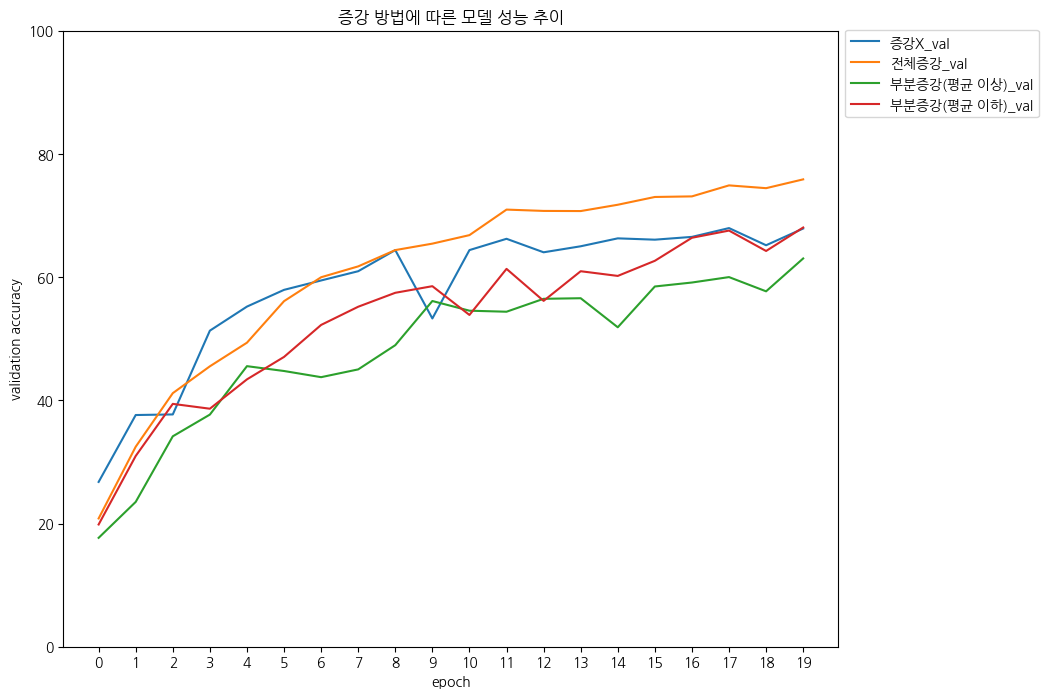

In [ ]:
score_df[['증강X_val', '전체증강_val', '부분증강(평균 이상)_val', '부분증강(평균 이하)_val']].plot(kind='line', figsize=(10, 8))
plt.title('증강 방법에 따른 모델 성능 추이')
plt.xlabel('epoch')
plt.xticks([i for i in range(20)])
plt.ylabel('validation accuracy')
plt.yticks([i for i in range(0, 101, 20)])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.013))
plt.show()

전체 증강을 했을 경우, 정확도가 가장 많이 올라간 것을 확인할 수 있었다.

**결론: 데이터 셋 전체 증강 방식을 채택한다.**



---



# 3. 선택지들의 성능 경향을 파악한다.


앞서 도출한 결론은 다음과 같다.

* 결론 1: 시간 효율을 위해 학습 epoch는 50으로 설정한다.
* 결론 2: 러닝레이트 스케쥴러는 10 epoch 별로 감소하도록 설정한다.
* 결론 3: 모든 데이터에 대해 증강을 수행한다.

아래에서는 위와 같은 방법을 이용해 최종 모델을 학습시킨다.

###데이터셋 전체 증강

In [ ]:
# 저장된 평균, 표준편차 로딩
load_route = '/content/drive/MyDrive/데이터 병합 관련/231031172524_normalize-params.pickle'
#미션 1 단계에서 저장한 normalize-params pickle
mean = load_pickle(load_route)['평균']
std = load_pickle(load_route)['표준편차']

# train 데이터 augmentation 하기
trans_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# val 데이터는 augmentation 안 함
trans_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [ ]:
#데이터 셋 로딩하기
#transform에 앞서 설정한 증강(trans_train)을 인자로 전달하여 전체 데이터 셋에 대한 증강을 진행한다)
trainset = ImageFolder(root='/content/drive/MyDrive/데이터/train', transform=trans_train)
testset = ImageFolder(root='/content/drive/MyDrive/데이터/val',  transform=trans_val)

# 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

### 모델 로딩

In [ ]:
# ResNet-18 모델 로딩
model = models.resnet18(pretrained=False)

# 분류할 클래스 수에 맞게 모델의 출력 레이어 수정
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)  # PyTorch 무작위 시드 설정
np.random.seed(seed)     # NumPy 무작위 시드 설정

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

cuda:0


In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 모델 학습시키기

*   해당 단계에서는 현 환경에서 직접 학습을 진행하지 않고 체크포인트를 첨부하는 것으로 대신한다. (첨부된 체크포인트는 Mission 2 최종 체크포인트와 동일하다)

[Mission2_231103034754_50epochs.pt](https://drive.google.com/file/d/1WsfFbltJ2QFT9rkZl5oBPUm1ELDQqC7k/view?usp=sharing)

[Mission2_231103033621_49epochs.pt](https://drive.google.com/file/d/13PvQQWZlu4lbPMtXzUZPiKzf22hzYQTP/view?usp=sharing)

In [ ]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 최적화 알고리즘 선택
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# learning Rate Scheduler
# 10 에폭마다 lr 감소하도록 함
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# 훈련 반복
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / (i + 1)
    accuracy = 100.0 * correct / total
    print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    scheduler.step()

    #매 에폭 별로 checkpoint 저장
    now = datetime.now().strftime('%y%m%d%H%M%S')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item()
    }, f'Mission2_{now}_{epoch+1}epochs.pt')

print('Training Finished')

### 정확도 확인하기

에포크 49 일 때 validation 정확도 불러오기

In [ ]:
# 모델 불러오기
# 모델과 옵티마이저를 초기화
model = models.resnet18(pretrained=False)
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
optimizer = torch.optim.Adam(model.parameters())

# 저장된 모델을 불러오기
model_path = '/content/drive/MyDrive/데이터 병합 관련/Mission2_231103033621_49epochs.pt'
model, optimizer, epoch, loss = load_model(model, optimizer, model_path)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


cuda:0


In [ ]:
validate_epoch(model, testloader, device)

에포크 50 일 때 validation 정확도 불러오기

In [ ]:
# 모델 불러오기
# 모델과 옵티마이저를 초기화
model = models.resnet18(pretrained=False)
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
optimizer = torch.optim.Adam(model.parameters())

# 저장된 모델을 불러오기
model_path = '/content/drive/MyDrive/데이터 병합 관련/Mission2_231103034754_50epochs.pt'
model, optimizer, epoch, loss = load_model(model, optimizer, model_path)

# CUDA 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

# 시드 설정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# GPU 시드 설정
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

cuda:0


In [ ]:
validate_epoch(model, testloader, device)

*컴퓨팅 단위의 문제로 현 환경에서 불가피하게 수행을 완료하지 못했다. 다만 로컬에서 validation accuarcy를 확인한 결과는 다음과 같다*

* 46 epochs 수행시 정확도 80.63363647460938
* 47 epochs 수행시 정확도 80.75273895263672
* 48 epochs 수행시 정확도 80.70509338378906
* 49 epochs 수행시 정확도 80.94330596923828
* 50 epochs 수행시 정확도 80.75273895263672

따라서 최종 결과를 보다 성능이 나은
[Mission2_231103033621_49epochs.pt](https://drive.google.com/file/d/13PvQQWZlu4lbPMtXzUZPiKzf22hzYQTP/view?usp=sharing)
로 제출하도록 한다. 다만 제출 편의상 체크 포인트 파일이름을 Mission2.pt로 임의 변경한다.